The code here is based on the paper Evolutionary consequences of polyploidy in prokaryotes and the origin of mitosis and meiosis
https://biologydirect.biomedcentral.com/articles/10.1186/s13062-016-0131-8

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [127]:
beneficial_mutation_rate = 0.01
k_deleterious = 0.05
k_beneficial = 0.1

class Cell:
    def __init__(self, initial_fitness=0.99, num_genes=100, ploidy=1):
        self.ploidy = ploidy
        self.num_genes = num_genes
        self.initial_fitness = initial_fitness
        self.genome = np.array([[initial_fitness for _ in range(num_genes)] for n in range(self.ploidy)])
        self.fitness = None
        self.effective_fitness = None
    
    def calculate_fitness(self):
        fitness = 1

        for i in range(self.num_genes):
            gene_fitness = np.max(self.genome[:, i])
            fitness *= gene_fitness/self.initial_fitness
        
        self.fitness = fitness
    
    def calculate_effective_fitness(self, population, s=0.3):
        min_fitness = population.min_fitness
        max_fitness = population.max_fitness
        divisor = (max_fitness - min_fitness) if max_fitness - min_fitness != 0 else 1

        self.effective_fitness = (1-s) * (self.fitness - min_fitness)/divisor + s * np.random.rand()
    
    def mutate(self, mutation_probability=0.007):
        for i, chromosome in enumerate(self.genome):
            for j, gene in enumerate(chromosome):
                mut = np.random.rand()

                if mut < mutation_probability:
                    beneficial = np.random.rand()

                    if beneficial < beneficial_mutation_rate:
                        self.genome[i, j] = 1 - (1 - gene) * (1 - k_beneficial)
                    else:
                        self.genome[i, j] = gene * (1 - k_deleterious)

    
    def divide(self):
        duplicated_genome = np.repeat(self.genome, 2, axis=0)
        np.random.shuffle(duplicated_genome)
        new_genome_1 = duplicated_genome[:self.ploidy]
        new_genome_2 = duplicated_genome[self.ploidy: 2*self.ploidy]
        
        new_cell_1 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=self.ploidy)
        new_cell_1.genome = new_genome_1
        new_cell_2 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=self.ploidy)
        new_cell_2.genome = new_genome_2

        return (new_cell_1, new_cell_2)

In [128]:
class Population:
    def __init__(self, size=4000, num_genes=100, ploidy=1):
        self.size = size
        self.cells = [Cell(num_genes=num_genes, ploidy=ploidy) for _ in range(size)]
        self.min_fitness = None
        self.max_fitness = None
    
    def __getitem__(self, i):
        return self.cells[i]

In [129]:
size=1000
ploidy=6
num_genes=100
mutation_probability=0.007

pop = Population(size=size, num_genes=num_genes, ploidy=ploidy)
average_fitness = []

for i in range(500):
    # cells reproduce
    new_cells = []

    for cell in pop.cells:
        new_cell_1, new_cell_2 = cell.divide()
        new_cells.append(new_cell_1)
        new_cells.append(new_cell_2)

    pop.cells = new_cells
    
    # mutate everyone
    for cell in pop.cells:
        cell.mutate(mutation_probability=mutation_probability)

    # calculate fitnesses
    for cell in pop.cells:
        cell.calculate_fitness()

    # kill cells with fitness below 0.5
    filtered_cells = [cell for cell in pop.cells if cell.fitness > 0.5]
    pop.cells = filtered_cells

    # get min and max fitness to calcualte effective fitness with
    if len(pop.cells) == 0: break

    fitnesses = [cell.fitness for cell in pop.cells]
    average_fitness.append(np.average(fitnesses))

    if len(pop.cells) < 2: break

    pop.min_fitness = np.min(fitnesses)
    pop.max_fitness = np.max(fitnesses)


    # calculate effective fitnesses
    for cell in pop.cells:
        cell.calculate_effective_fitness(pop)

    # sort population by effective fitness select top population_size cells
    pop.cells.sort(key=lambda x: x.effective_fitness)
    pop.cells = pop.cells[max(len(pop.cells) - pop.size - 1, 0):]

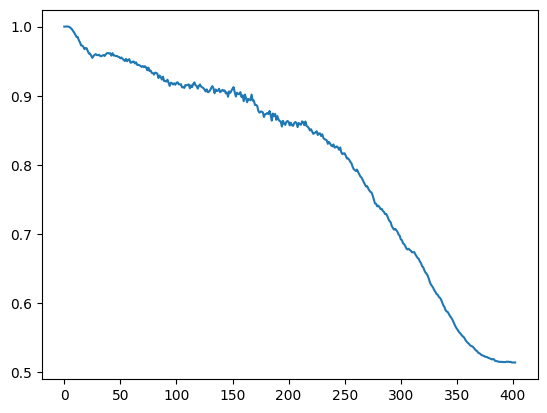

In [130]:
fig, ax = plt.subplots()

ax.plot(average_fitness)